<a href="https://colab.research.google.com/github/doogzultz/time_series_project/blob/main/Preprocessing_and_model_testing_w_gbtrees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing and model testing
This code is meant to organized the data, scale it, drop the appropriate features, and train/test it on various models.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Dropout, Input, \
Flatten, Concatenate, Conv1D, LSTM, Bidirectional, BatchNormalization, Activation, TimeDistributed, Lambda, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.utils import shuffle
from tensorflow.keras.utils import plot_model
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer, mean_absolute_percentage_error
import xgboost
from xgboost.sklearn import XGBRegressor
import os

In [2]:
tf.__version__, sklearn.__version__, mpl.__version__, xgboost.__version__

('2.8.2', '1.0.2', '3.2.2', '0.90')

In [3]:
''' Some global variables that we set '''

class g:
  batch_size = 32 #batch size for training nn's
  valid_cut = '2011-08-15'# an extra split in case I wanted it for parameter tuning
  test_cut = '2011-10-01' # the date after which we will consider data for testing
  valid = False #valid split
  drop_extra_factors = True #dropping factors that don't seem to be as useful from data
  smape_threshold = .5 #threshold for the smape and mape metric
  smape_epsilon = 1e-3 #to prevent division by 0 in smape and mape metric
  window_size = 8 #window size for training the LSTM model

## Data oraganization and preprocessing
* We organize the data into dictionaries of time series, one for each identifer.
* We one-hot encode the 'sector' feature, and provide an option to drop all factors except 2 and 9.
* Finally, we scale the remaining numerical features and target.

In [4]:
url = 'https://drive.google.com/uc?export=download&id=1sObzDP-D7DrGLkf7MXTI_NXfrvo2biRU'
data = pd.read_csv(url)

In [5]:
data.columns

Index(['date', 'identifier', 'market_cap', 'sector', 'index_membership',
       'factor_1', 'factor_2', 'factor_3', 'factor_4', 'factor_5', 'factor_6',
       'factor_7', 'factor_8', 'factor_9', 'factor_10', 'target'],
      dtype='object')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32202 entries, 0 to 32201
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              32202 non-null  object 
 1   identifier        32202 non-null  object 
 2   market_cap        32202 non-null  float64
 3   sector            32202 non-null  int64  
 4   index_membership  32202 non-null  bool   
 5   factor_1          32202 non-null  float64
 6   factor_2          32202 non-null  float64
 7   factor_3          32202 non-null  float64
 8   factor_4          32202 non-null  float64
 9   factor_5          32202 non-null  float64
 10  factor_6          32202 non-null  float64
 11  factor_7          32202 non-null  float64
 12  factor_8          32202 non-null  float64
 13  factor_9          32202 non-null  float64
 14  factor_10         32202 non-null  float64
 15  target            32202 non-null  float64
dtypes: bool(1), float64(12), int64(1), objec

In [7]:
''' From the data_analysis file, we know that index_membership is always True '''

data.drop(columns = 'index_membership', inplace = True)

In [8]:
''' We plan to view the data as a table of time series '''

data.sort_values(by = ['identifier', 'date'], inplace = True)
data

,date,identifier,market_cap,sector,factor_1,factor_2,factor_3,factor_4,factor_5,factor_6,factor_7,factor_8,factor_9,factor_10,target
82,2010-01-06,AD41WBQFVG43,5.843968e+10,35,0.766639,-0.000032,0.832677,0.500608,0.193489,0.246089,0.753702,0.792736,-0.000005,0.109029,-0.000006
400,2010-01-13,AD41WBQFVG43,4.758865e+10,35,0.907349,-0.022933,0.346457,0.581694,0.648483,0.872304,0.723412,0.333230,-0.009504,0.121348,-0.008721
718,2010-01-20,AD41WBQFVG43,3.374757e+10,35,0.476465,-0.000114,0.592328,0.379747,0.810961,0.017737,0.619208,0.058918,-0.000099,0.890898,-0.000081
1036,2010-01-27,AD41WBQFVG43,4.908395e+10,35,0.265141,-0.000034,0.521405,0.682492,0.547349,0.155915,0.068966,0.699718,-0.000037,0.355059,-0.000018
1354,2010-02-03,AD41WBQFVG43,2.729189e+10,35,0.423987,0.000197,0.950500,0.628533,0.956287,0.426634,0.752799,0.961276,0.000163,0.196711,0.000318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12552,2010-10-06,ZMYXRS4KVOG2,6.504496e+08,25,0.069622,0.009936,0.588354,0.447469,0.353549,0.767779,0.790632,0.308049,0.012255,0.281193,0.005117
12862,2010-10-13,ZMYXRS4KVOG2,1.403710e+09,25,0.343444,0.002566,0.394802,0.143162,0.116762,0.744089,0.825323,0.559633,0.001058,0.755124,0.000446
13172,2010-10-20,ZMYXRS4KVOG2,7.284687e+08,25,0.857557,0.000146,0.892729,0.113346,0.574870,0.990100,0.319424,0.591153,0.000054,0.933679,0.000035
13483,2010-10-27,ZMYXRS4KVOG2,7.766592e+08,25,0.093894,-0.000885,0.311392,0.768537,0.589851,0.289180,0.431484,0.373209,-0.000411,0.225972,-0.000242


In [9]:
''' Checking of 0 values '''

(data== 0).sum(axis=0)

date           0
identifier     0
market_cap     0
sector         0
factor_1       0
factor_2      68
factor_3       0
factor_4       0
factor_5       0
factor_6       0
factor_7       0
factor_8       0
factor_9      68
factor_10      0
target        68
dtype: int64

In [10]:
''' saving identifier counts as a variable '''

ident_counts= data.value_counts('identifier')
ident_counts

identifier
AD41WBQFVG43    104
UZ4DWDZ8ALZ4    104
KR47536Y10D4    104
KPJ8FTV9ESJ3    104
KMHQ727PU8E2    104
               ... 
PNUM57CYEB27      5
KHKNKSMXBWP3      5
LYCPQJ19AOY0      5
RENR64FT3I74      5
LALJLSN9UMP2      2
Length: 356, dtype: int64

([<matplotlib.axis.XTick at 0x7f462fe09f90>,
 [Text(0, 0, '2010-01-06'), Text(0, 0, '2011-12-28')])

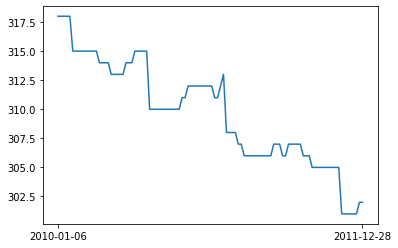

In [11]:
''' Checking the distribution of dates.
    It seems that some date steps could have been skipped for certain identifiers '''

plt.plot(data.value_counts('date').sort_index())
plt.xticks(range(0,104,103), ('2010-01-06', '2011-12-28'))

In [12]:
''' changing the data type of the date column, in order to use as orderable index '''

data = data.astype({'date':np.datetime64})

In [13]:
''' we want to split the data into train and test sets.
    We will split after a certain date accross all identifiers.
    Here, we check to make sure the distribution of sectors
        is comparable before and after the split
        in order to give an accurate indication of performance'''


data.value_counts('sector', normalize = True).sort_index()

sector
10    0.049221
15    0.093162
20    0.208527
25    0.132849
30    0.072759
35    0.049003
40    0.232812
45    0.051674
50    0.038352
55    0.071642
dtype: float64

In [14]:
data[data['date']<g.test_cut].value_counts('sector', normalize = True).sort_index()

sector
10    0.049103
15    0.093537
20    0.207769
25    0.133689
30    0.071568
35    0.049386
40    0.234231
45    0.051509
50    0.037712
55    0.071497
dtype: float64

In [15]:
data[data['date']>g.test_cut].value_counts('sector', normalize = True).sort_index()

sector
10    0.050064
15    0.090470
20    0.213977
25    0.126811
30    0.081321
35    0.046252
40    0.222618
45    0.052859
50    0.042948
55    0.072681
dtype: float64

In [16]:
''' One-hot encoding the sectors.
    Tried one-hot encoding identifiers, performance difference was not perceptible '''

sector_onehot = pd.get_dummies(data['sector'], prefix='sector')
#ident_onehot = pd.get_dummies(data['identifier'], prefix='ident')
#ident_onehot.head()

In [17]:
''' dropping original sector column, adding one-hots, and putting target at the last column '''

target = data['target']
data.drop(columns = ['sector', 'target'], inplace = True)
data = pd.concat([data, sector_onehot, target], axis = 1)
data.columns

Index(['date', 'identifier', 'market_cap', 'factor_1', 'factor_2', 'factor_3',
       'factor_4', 'factor_5', 'factor_6', 'factor_7', 'factor_8', 'factor_9',
       'factor_10', 'sector_10', 'sector_15', 'sector_20', 'sector_25',
       'sector_30', 'sector_35', 'sector_40', 'sector_45', 'sector_50',
       'sector_55', 'target'],
      dtype='object')

In [18]:
def split_to_series(df,valid_cut = g.valid_cut, valid = g.valid, test_cut= g.test_cut, drop_non_complete = False):
    '''
    puts each identifer time series into a dictionary value and outputs two or three dictionaries corresponding to train/test/valid
    
    args:
        df -- dataframe
        valid_cut -- date to cut for validation set, not used if valid = False
        valid -- do valididation cut
        test_cut -- date for test cut
        drop_non_complete -- use only series with 104 entries if True
    returns
        train and test dictionary with numerical keys corresponding to some time sub-series
        with valid dictionary if valid = True
        '''
    
    
    series_dict = {}
    train_dict = {}
    valid_dict = {0: pd.DataFrame(columns = data.columns)} #empty dataframe in case we want a valid split as well
    test_dict = {0: pd.DataFrame(columns = data.columns)}
    for i, ident in enumerate(df.value_counts('identifier').index):
        #first we separate by identifier and index by date, add each to series_dict
        #then we cut each series in series_dict by the specified dates and add the subseries to the appropriate train/test/valid dictionaries

        if df[df['identifier'] == ident].shape[0]<104 and drop_non_complete == True:
          continue
        series_dict[i] = df[df['identifier'] == ident].set_index('date', verify_integrity= True).sort_index()
        if valid == True:
          #see below for explanation

          train_dict[i] = series_dict[i].loc[:valid_cut]
          valid_dict[i] = series_dict[i].loc[valid_cut:test_cut]
          test_dict[i] = series_dict[i].loc[test_cut:]
        else:
          #separate each series into train and test sets, where we cut by test_cut and
          #add the data after test_cut to test_dict

          train_dict[i] = series_dict[i].loc[:test_cut]
          test_dict[i] = series_dict[i].loc[test_cut:] 

    #Finally, we calculate the train split size in terms of series and time steps    

    print(f"Number of series to be trained: {len([key for key, value in train_dict.items() if value.shape[0]>0])}")
    print(f"Number of series to be validated: {len([key for key, value in valid_dict.items() if value.shape[0]>0])}")
    print(f"Number of series to be tested: {len([key for key, value in test_dict.items() if value.shape[0]>0])}")
    train_length = sum([value.shape[0] for key, value in train_dict.items()])
    valid_length = sum([value.shape[0] for key, value in valid_dict.items()])
    test_length = sum([value.shape[0] for key, value in test_dict.items()])

    print(f"Number of time steps to be trained: {train_length}")
    print(f"Number of time steps to be validated: {valid_length}")
    print(f"Number of time steps to be tested: {test_length}")
    print(f"Train_proportion: {train_length/(train_length+valid_length+test_length)}")

    return train_dict, valid_dict, test_dict

In [19]:
''' make the split(s), valid_dict could be empty '''

train_dict, valid_dict, test_dict = split_to_series(data)

Number of series to be trained: 349
Number of series to be validated: 0
Number of series to be tested: 313
Number of time steps to be trained: 28267
Number of time steps to be validated: 0
Number of time steps to be tested: 3935
Train_proportion: 0.8778026209552202


In [20]:
'''checking different dictionary entries
    '''

train_dict[56].info()
print(train_dict[56].value_counts('identifier'))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 91 entries, 2010-01-06 to 2011-09-28
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   identifier  91 non-null     object 
 1   market_cap  91 non-null     float64
 2   factor_1    91 non-null     float64
 3   factor_2    91 non-null     float64
 4   factor_3    91 non-null     float64
 5   factor_4    91 non-null     float64
 6   factor_5    91 non-null     float64
 7   factor_6    91 non-null     float64
 8   factor_7    91 non-null     float64
 9   factor_8    91 non-null     float64
 10  factor_9    91 non-null     float64
 11  factor_10   91 non-null     float64
 12  sector_10   91 non-null     uint8  
 13  sector_15   91 non-null     uint8  
 14  sector_20   91 non-null     uint8  
 15  sector_25   91 non-null     uint8  
 16  sector_30   91 non-null     uint8  
 17  sector_35   91 non-null     uint8  
 18  sector_40   91 non-null     uint8  
 19  sector_45  

In [21]:
valid_dict[0].info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        0 non-null      object
 1   identifier  0 non-null      object
 2   market_cap  0 non-null      object
 3   factor_1    0 non-null      object
 4   factor_2    0 non-null      object
 5   factor_3    0 non-null      object
 6   factor_4    0 non-null      object
 7   factor_5    0 non-null      object
 8   factor_6    0 non-null      object
 9   factor_7    0 non-null      object
 10  factor_8    0 non-null      object
 11  factor_9    0 non-null      object
 12  factor_10   0 non-null      object
 13  sector_10   0 non-null      object
 14  sector_15   0 non-null      object
 15  sector_20   0 non-null      object
 16  sector_25   0 non-null      object
 17  sector_30   0 non-null      object
 18  sector_35   0 non-null      object
 19  sector_40   0 non-null      object
 20  sector_45   0 non-null     

In [22]:
test_dict[56].info()
print(test_dict[56].value_counts('identifier'))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13 entries, 2011-10-05 to 2011-12-28
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   identifier  13 non-null     object 
 1   market_cap  13 non-null     float64
 2   factor_1    13 non-null     float64
 3   factor_2    13 non-null     float64
 4   factor_3    13 non-null     float64
 5   factor_4    13 non-null     float64
 6   factor_5    13 non-null     float64
 7   factor_6    13 non-null     float64
 8   factor_7    13 non-null     float64
 9   factor_8    13 non-null     float64
 10  factor_9    13 non-null     float64
 11  factor_10   13 non-null     float64
 12  sector_10   13 non-null     uint8  
 13  sector_15   13 non-null     uint8  
 14  sector_20   13 non-null     uint8  
 15  sector_25   13 non-null     uint8  
 16  sector_30   13 non-null     uint8  
 17  sector_35   13 non-null     uint8  
 18  sector_40   13 non-null     uint8  
 19  sector_45  

In [23]:
''' Preparing numerical features for scaling '''

numerical_features = ['market_cap']+list(data.loc[:,'factor_1':'factor_10'].columns)+['target']
numerical_features

['market_cap',
 'factor_1',
 'factor_2',
 'factor_3',
 'factor_4',
 'factor_5',
 'factor_6',
 'factor_7',
 'factor_8',
 'factor_9',
 'factor_10',
 'target']

In [24]:
def scale_and_drop_columns(train_dict, valid_dict, test_dict, numerical_features, drop_extra_factors = g.drop_extra_factors):
    ''' Scales the features and target based on the mean/std of the entire training set and possibly drops features
    
    args:
        train_dict, valid_dict, test_dict are dicitonaries
        numerical features -- the features/target we wish to scale
        drop_extra_factors --- if True, drops all "factors" except 2 and 9
        
    returns:
        2 or 3 dictionaries which are scaled and ready for training after an appropriate concatenation
        mean and std of input training set features/target'''
    
    train_df = pd.concat(train_dict, ignore_index = True)
    t_mean = np.mean(train_df[numerical_features], axis = 0)
    t_std = np.std(train_df[numerical_features], axis = 0)
    # each for loop scaled and drops features for each dicitonary entry in train/test/valid
    
    for i in range(0,len(train_dict)):
        train_dict[i][numerical_features] = (train_dict[i][numerical_features]-t_mean)/t_std
        train_dict[i].drop(columns = ['identifier'], inplace = True)
        if drop_extra_factors ==True:
          train_dict[i].drop(columns = ['factor_1', 'factor_3', 'factor_4', 'factor_5', 'factor_6', 
                                        'factor_7', 'factor_8', 'factor_10'], inplace= True)
    for i in range(0,len(valid_dict)):
        valid_dict[i][numerical_features] = (valid_dict[i][numerical_features]-t_mean)/t_std
        valid_dict[i].drop(columns = ['identifier'], inplace = True)
        if drop_extra_factors ==True:
          valid_dict[i].drop(columns = ['factor_1', 'factor_3', 'factor_4', 'factor_5', 'factor_6', 
                                        'factor_7', 'factor_8', 'factor_10'], inplace= True)
    for i in range(0,len(test_dict)):
        test_dict[i][numerical_features] = (test_dict[i][numerical_features]-t_mean)/t_std
        test_dict[i].drop(columns = ['identifier'], inplace = True)
        if drop_extra_factors ==True:
          test_dict[i].drop(columns = ['factor_1', 'factor_3', 'factor_4', 'factor_5', 'factor_6', 
                                        'factor_7', 'factor_8', 'factor_10'], inplace= True)
    return train_dict, valid_dict, test_dict, t_mean, t_std


In [25]:
train_final, valid_final, test_final, t_mean, t_std= \
scale_and_drop_columns(train_dict, valid_dict, test_dict, numerical_features)

In [26]:
t_mean, t_std

(market_cap    1.111389e+10
 factor_1      4.985447e-01
 factor_2     -1.913018e-04
 factor_3      5.000637e-01
 factor_4      4.988483e-01
 factor_5      5.005490e-01
 factor_6      5.000944e-01
 factor_7      4.979793e-01
 factor_8      4.986385e-01
 factor_9     -2.047397e-04
 factor_10     4.986891e-01
 target       -2.058015e-04
 dtype: float64, market_cap    1.589832e+10
 factor_1      2.890597e-01
 factor_2      5.703728e-03
 factor_3      2.890388e-01
 factor_4      2.889261e-01
 factor_5      2.891119e-01
 factor_6      2.878230e-01
 factor_7      2.877822e-01
 factor_8      2.890916e-01
 factor_9      5.954812e-03
 factor_10     2.872727e-01
 target        5.718353e-03
 dtype: float64)

In [27]:
'''checking organization for various dictionary entries '''

train_final[300].info(), valid_final[0].info(), test_final[300].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 47 entries, 2010-11-10 to 2011-09-28
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   market_cap  47 non-null     float64
 1   factor_2    47 non-null     float64
 2   factor_9    47 non-null     float64
 3   sector_10   47 non-null     uint8  
 4   sector_15   47 non-null     uint8  
 5   sector_20   47 non-null     uint8  
 6   sector_25   47 non-null     uint8  
 7   sector_30   47 non-null     uint8  
 8   sector_35   47 non-null     uint8  
 9   sector_40   47 non-null     uint8  
 10  sector_45   47 non-null     uint8  
 11  sector_50   47 non-null     uint8  
 12  sector_55   47 non-null     uint8  
 13  target      47 non-null     float64
dtypes: float64(4), uint8(10)
memory usage: 2.3 KB
<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0

(None, None, None)

In [28]:
def shuffle_and_aggregate(data_dict, shuffle_ = True):
    ''' shuffles if shuffle = True and concatenates all entries of the input dictionary '''


    data_agg = pd.concat(data_dict, axis = 0)
    if shuffle_ == True:
        data_agg = shuffle(data_agg)
    target = data_agg['target']
    data_agg = data_agg.drop(columns = 'target')
    return data_agg, target
    

In [29]:
x_train, y_train = shuffle_and_aggregate(train_final)
x_valid, y_valid = shuffle_and_aggregate(valid_final, shuffle_= False)
x_test, y_test = shuffle_and_aggregate(test_final, shuffle_=False)


## Model testing and evaluation
* We train and test the data on a barrage of models, including:
    * baseline models such as predict last value, predict last year's value, or predict 0
    * a linear model
    * a random forest regressor
    * gradient boosted trees
    * a dense neural network model
    * a time dependent LSTM/dense hybrid network
* The main metrics we use are:
    * SMAPE = $$\frac{1}{m}\sum_1^m\frac{2\vert y_{true}-y_{pred}\vert}{\max(\vert y_{true}\vert+\vert y_{pred}\vert +\epsilon,\, threshold+\epsilon)})$$
    
    * MAPE = $$\frac{1}{m}\sum_1^m\frac{\vert y_{true}-y_{pred}\vert}{\max(\vert y_{true}\vert +\epsilon,\, threshold+\epsilon)})$$
        both with a threshold of 0.5, and
    
    * mean absolute error (mae)
    
* In retrospect, the trainable models did not perform substantially different in these regards, with the except of the hybrid LSTM model, which performed worse
* Recommendation depends on the application, but I personally would choose the random forest model or dense nn, with the latter allowing for further parameter
    tuning and customizability after gathering more data in the future.

In [30]:
def create_mape_np(epsilon = g.smape_epsilon, threshold = g.smape_threshold, mean = True):
    ''' creates a "mean absolute percentage error" metric for numeric input
        args:
        threshold -- value pairs with actual below threshold will be measured like mean absolute error,
                    above the threshold scaled as a percentage of actual
        epsilon -- to prevent division by zero 
        mean -- average the errors'''
    def mape(y_true, y_pred, **kwargs):
        sum_ = np.maximum(np.abs(y_true) + epsilon, threshold+epsilon)
        if mean == False:
            return 100*np.abs(y_pred - y_true) / sum_
        else:
            return -np.mean(100*np.abs(y_pred - y_true) / sum_)
    return mape

In [31]:
def create_smape_np(epsilon = g.smape_epsilon, threshold = g.smape_threshold, mean = True):
    ''' creates a "symmetric mean absolute percentage error" metric for numeric input
        args:
        threshold -- value pairs with actual below threshold will be measured like mean absolute error,
                    above the threshold scaled as a percentage of actual
        epsilon -- to prevent division by zero 
        mean -- average the errors'''

    def smape(y_true, y_pred, **kwargs):
        sum_ = np.maximum(np.abs(y_true) + np.abs(y_pred) + epsilon, threshold+epsilon)
        if mean == False:
            return 100*np.abs(y_pred - y_true) / sum_*2
        else:
            return -np.mean(100*np.abs(y_pred - y_true) / sum_ *2)
    return smape

In [32]:
smape = create_smape_np()
mape = create_mape_np()

smape_score = make_scorer(create_smape_np(), higher_is_better = False)
mape_score = make_scorer(create_mape_np(), higher_is_better = False)

### We test some baseline models to get an idea of what performance we should expect.
* Predict zero: This model did the best out of the naive models, which makes sense since there seems to be a lot of
    time steps with close to zero return.
* Predict last value, predict average of three last values: Performed the worse than predict zero.
* Predict last year's value, or the moving average of 3 time steps from last year: Performed the worst, which shows that we do not have yearly seasonality.

In [33]:
def naive_models(valid_scaled, metrics = {'smape':create_smape_np(mean = False), 'mape': create_mape_np(mean = False)}):
    ''' This give a baseline model: using the last value as the future value, the mean of the last three values, and zero
    
    args:
        valid_scaled -- test dictionary
        metrics -- metric dictionary '''
    
    
    
    
    total_smape_0 = 0
    total_smape = 0
    total_smape_3 = 0
    total_mae_0 = 0
    total_mae = 0
    total_mae_3 = 0
    total_mape_0 = 0
    total_mape = 0
    count_0=0
    count = 0
    count_3 = 0
    for i in range(0, len(valid_scaled)):
        if valid_scaled[i].shape[0]>0:
            total_smape_0 += np.sum(metrics['smape'](np.zeros(valid_scaled[i].shape[0], dtype = np.float32), np.asarray(valid_scaled[i].iloc[:,-1])))
            total_mape_0 += np.sum(metrics['mape'](np.asarray(valid_scaled[i].iloc[:,-1]),np.zeros(valid_scaled[i].shape[0], dtype = np.float32)))
            total_smape += np.sum(metrics['smape'](np.asarray(valid_scaled[i].iloc[1:,-1]), np.asarray(valid_scaled[i].iloc[:-1,-1])))
            total_mape += np.sum(metrics['mape'](np.asarray(valid_scaled[i].iloc[1:,-1]), np.asarray(valid_scaled[i].iloc[:-1,-1])))
            total_smape_3 += np.sum(metrics['smape'](np.asarray(valid_scaled[i].iloc[3:,-1]),
                                                     (1/3)*(np.asarray(valid_scaled[i].iloc[:-3,-1])
                                                     +np.asarray(valid_scaled[i].iloc[1:-2,-1])
                                                     +np.asarray(valid_scaled[i].iloc[2:-1,-1]))))
            total_mae_0 += np.sum(abs(np.zeros(valid_scaled[i].shape[0], dtype = np.float32)-np.asarray(valid_scaled[i].iloc[:,-1])))
            total_mae += np.sum(abs(np.asarray(valid_scaled[i].iloc[1:,-1])-np.asarray(valid_scaled[i].iloc[:-1,-1])))
            total_mae_3 += np.sum(abs(np.asarray(valid_scaled[i].iloc[3:,-1])-(1/3)*(np.asarray(valid_scaled[i].iloc[:-3,-1])
                                                                                  +np.asarray(valid_scaled[i].iloc[1:-2,-1])
                                                                                  +np.asarray(valid_scaled[i].iloc[2:-1,-1]))))
            count_0+=valid_scaled[i]['target'].shape[0]
            count += valid_scaled[i]['target'].shape[0]-1
            count_3 += valid_scaled[i]['target'].shape[0]-3
        else:
            continue
    print(f"Predicting with the mean (zero) gives a SMAPE of {total_smape_0/count_0} \
, an MAE of {total_mae_0/count_0}, and a MAPE of {total_mape_0/count_0}")
    print(f"Predicting with last value gives a SMAPE of {total_smape/count} \
, an MAE of {total_mae/count}, and a MAPE of {total_mape/count}")
  
    print(f"Predicting with avererage of the last 3 values gives a SMAPE of {total_smape_3/count_3} \
and an MAE of {total_mae_3/count_3}")
    return



In [34]:
''' we run the naive models on the whole data set with only complete series and also on the test set '''

naive_test_data, blank, blank_2= split_to_series(data,valid_cut = None, valid = False, test_cut= '2012-01-01', drop_non_complete = True)
naive_test_data, blank, blank_2, mean, std = scale_and_drop_columns(naive_test_data, blank, blank_2, numerical_features)

naive_models(naive_test_data)

Number of series to be trained: 271
Number of series to be validated: 0
Number of series to be tested: 0
Number of time steps to be trained: 28184
Number of time steps to be validated: 0
Number of time steps to be tested: 0
Train_proportion: 1.0
Predicting with the mean (zero) gives a SMAPE of 67.09561349870656 , an MAE of 0.3615971525588669, and a MAPE of 33.54780674935328
Predicting with last value gives a SMAPE of 83.69587629649352 , an MAE of 0.5565116092751653, and a MAPE of 74.72881966818849
Predicting with avererage of the last 3 values gives a SMAPE of 93.09097649746099 and an MAE of 0.523842334067982


In [35]:
''' testing the naive models on the test set, which may have missing time steps '''

naive_models(test_final)

Predicting with the mean (zero) gives a SMAPE of 74.29249034332256 , an MAE of 0.44632912126987584, and a MAPE of 37.14624517166128
Predicting with last value gives a SMAPE of 93.40561160014964 , an MAE of 0.7107571052869068, and a MAPE of 92.7638038333415
Predicting with avererage of the last 3 values gives a SMAPE of 99.85240650648245 and an MAE of 0.6525911281776178


In [36]:
def seasonal_model(valid_scaled, metrics = {'smape':create_smape_np(mean = False), 'mape': create_mape_np(mean = False)}):
    ''' Another baseline model: using last year's value as the future value, 
        or the centered average window of step size 3 from last year.
    
    args:
        valid_scaled = data_dictionary (ordered by date)
        metrics -- metric dictionary '''
    total_smape_3=0
    total_mae_3=0
    total_mape_3=0
    count_3=0
    
    total_smape = 0
    total_mae = 0
    total_mape = 0
    count = 0
    for i in range(0, len(valid_scaled)):
        if valid_scaled[i].shape[0]>0:
            total_smape += np.sum(metrics['smape'](np.asarray(valid_scaled[i].iloc[52:,-1]), np.asarray(valid_scaled[i].iloc[:-52,-1])))
            total_mape += np.sum(metrics['mape'](np.asarray(valid_scaled[i].iloc[52:,-1]), np.asarray(valid_scaled[i].iloc[:-52,-1])))
            total_smape_3 += np.sum(metrics['smape'](np.asarray(valid_scaled[i].iloc[53:,-1]),
                                                     (1/3)*(np.asarray(valid_scaled[i].iloc[1:-52,-1])
                                                     +np.asarray(valid_scaled[i].iloc[:-53,-1])
                                                     +np.asarray(valid_scaled[i].iloc[2:-51,-1]))))
            total_mape_3 += np.sum(metrics['mape'](np.asarray(valid_scaled[i].iloc[53:,-1]),
                                                     (1/3)*(np.asarray(valid_scaled[i].iloc[1:-52,-1])
                                                     +np.asarray(valid_scaled[i].iloc[:-53,-1])
                                                     +np.asarray(valid_scaled[i].iloc[2:-51,-1]))))
            total_mae += np.sum(abs(np.asarray(valid_scaled[i].iloc[52:,-1])-np.asarray(valid_scaled[i].iloc[:-52,-1])))
            total_mae_3 += np.sum(abs(np.asarray(valid_scaled[i].iloc[53:,-1])-(1/3)*(np.asarray(valid_scaled[i].iloc[1:-52,-1])
                                                                                  +np.asarray(valid_scaled[i].iloc[:-53,-1])
                                                                                  +np.asarray(valid_scaled[i].iloc[2:-51,-1]))))

            count += valid_scaled[i]['target'].shape[0]-52
            count_3 += valid_scaled[i]['target'].shape[0]-53
        else:
            continue
    print(f"Predicting with the the centered window average of 3 steps from last year gives a SMAPE of {total_smape_3/count_3} \
, an MAE of {total_mae_3/count_3}, and a MAPE of {total_mape_3/count_3}")
    print(f"Predicting with last year's value gives a SMAPE of {total_smape/count} \
, an MAE of {total_mae/count}, and a MAPE of {total_mape/count}")

    return



In [37]:
''' Testing the seasonal model on the set of complete time series 
    very poor performance in retrospect, indicating no yearly seasonality'''

seasonal_model(naive_test_data)

Predicting with the the centered window average of 3 steps from last year gives a SMAPE of 104.28726000463186 , an MAE of 0.599460701330063, and a MAPE of 72.87570950538543
Predicting with last year's value gives a SMAPE of 95.97756634999791 , an MAE of 0.6345810408792786, and a MAPE of 79.30535626127818


### Classical models
* We train and test the data on classical models: linear regression, random forests, and gradient boosted trees

In [38]:
'''trying first real model 
    degree optimized on earlier validation set'''

poly = PolynomialFeatures(degree = 1)
poly_train = poly.fit_transform(x_train)
poly_test = poly.transform(x_test)
lin_reg = LinearRegression()
lin_reg.fit(poly_train, y_train)
, , 
print("mae:", mean_absolute_error(lin_reg.predict(poly_test), y_test), " smape:", smape(lin_reg.predict(poly_test), y_test), " mape:", mape(y_test, lin_reg.predict(poly_test)))

mae: 0.2466591729495038  smape: -32.38065740919386  mape: -24.955454306226073


In [39]:
def model_cv(model, parameters, x_train, y_train, x_valid, y_valid, scoring = smape_score, refit = 'smape', verbose = False):
    ''' small function which runs grid search cross validation according to preference '''
    
    model = GridSearchCV(model, param_grid=parameters, scoring = scoring, refit = refit, cv = 3)
    model.fit(x_train, y_train)
    performance = model.score(x_valid, y_valid)
    if verbose ==False:
        print(f'{model.best_params_}\n cv_score = {model.best_score_}\n valid_score = {performance}'),
        return model
    
    else:
        print(f'{model.best_params_}\n cv_score = {model.best_score_}\n valid_score = {performance}\n'), pd.DataFrame(model.cv_results_).sort_values('mean_test_score'), 
        return model

In [40]:
''' cross validation on the train set was used to optimize parameters for the random forest model '''

# randforest = RandomForestRegressor(n_jobs = -1, random_state = 7)
# parameters = {#'n_estimators':[50, 100, 200], 
#               'max_depth': [6,8,10],
#      #'min_samples_split': [2,4,6],
#      'min_samples_leaf': [8,10,15 ],
#      #'criterion' :['absolute_error', 'squared_error']
#      }
# model_cv(randforest, parameters, x_train, y_train, x_valid, y_valid, verbose = True)

' cross validation on the train set was used to optimize parameters for the random forest model '

In [41]:
''' refitting random forest with best parameters on the entire train set and evaluating on test'''

randforest_test = RandomForestRegressor(n_jobs = -1, random_state = 8, n_estimators = 200, max_depth = 8, min_samples_leaf = 15)
randforest_test.fit(x_train, y_train)
y_pred = randforest_test.predict(x_test)
print("mae:", mean_absolute_error(y_pred, y_test), " smape:", smape(y_test, y_pred), " mape:", mape(y_test, y_pred))


mae: 0.24936700685262403  smape: -31.558674564608882  mape: -26.719965560993256


In [51]:
from xgboost.sklearn import XGBRegressor
''' fitting with gradient-boosted random forest (has l2 regularization built in)'''
param = {'max_depth': [6,8,10], 'min_child_weight': [15,20, 25], 
         'tree_method':['approx', 'hist'], 'grow_policy':['depthwise', 'lossguide'],
         'subsample':[0.5, 1]}
xgb_reg = XGBRegressor(num_boost_round = 100, early_stopping_rounds = 10,
            metric = 'mae', learning_rate = .1, num_jobs = -1)
xgb_reg = model_cv(xgb_reg, param, x_train, y_train, x_test, y_test, verbose = True, scoring = 'neg_mean_absolute_error', refit= True)

#dtrain = xgboost.DMatrix(np.asarray(x_train), label= np.asarray(y_train))

#xgboost.cv(param,dtrain,nfold = 3,  metrics = 'mae', num_boost_round = 50, early_stopping_rounds = 10)
#xgb_reg.fit(X = np.asarray(x_train), y = np.asarray(y_train), eval_set = [(np.asarray(x_test), np.asarray(y_test))],)

[07:29:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:29:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:29:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:29:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:29:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:29:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:29:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:29:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [52]:
smape = create_smape_np(mean = True)
mape = create_mape_np(mean = True)

In [53]:
''' performance of gradient boosted trees '''


y_pred =xgb_reg.predict(x_test)
print("mae:", mean_absolute_error(np.asarray(y_test), y_pred), " smape:", smape(np.asarray(y_test), y_pred), " mape:", mape(np.asarray(y_test), y_pred))

mae: 0.25555585770270495  smape: -31.81289652123448  mape: -26.961398520684597


### Neural network models
* we train and test thje data on two neural networks models: a dense model and a hybrid LSTM/Dense model.

In [ ]:
''' smape metric for output of neural networks '''

def create_smape(epsilon = g.smape_epsilon, threshold = g.smape_threshold):
    def smape(y_true, y_pred):
        summ = K.maximum(K.abs(y_true) + K.abs(y_pred)+epsilon, threshold + epsilon)
        return 100*K.abs(y_pred - y_true) / summ *2
    return smape

In [ ]:
''' mape metric for output of neural networks '''

def create_mape(epsilon = g.smape_epsilon, threshold = g.smape_threshold):
    def mape(y_true, y_pred):
        summ = K.maximum(K.abs(y_true)+epsilon, threshold + epsilon)
        return 100*K.abs(y_pred - y_true) / summ
    return mape

In [ ]:
def plot_model_perf(history, metric = None):
    ''' plots the loss and metric curves of a neural network model with regard to epoch '''
    
    plt.subplots(len([metric]), 1, figsize=(12, 8))
    epochs = range(len(history.history['loss']))
    plt.plot( epochs, history.history['loss'],color = 'blue', label = 'loss' )
    plt.plot(epochs, history.history['val_loss'], color = 'red', label = 'val_loss' )
    plt.legend()
    plt.show()
    if metric:
        for i, metric in enumerate(metric):
            plt.figure(figsize=(12, 8))
            plt.plot( epochs, history.history[f'{metric}'],color = 'green', label = f'{metric}' )
            plt.plot(epochs, history.history[f'val_{metric}'], color = 'orange', label = f'val_{metric}' )
            plt.legend()
            plt.show()

In [ ]:
def dense_block(input_, dense_units, dr):
    ''' A dense 2 layer block with relu activation, dropout, and regularization.
        args:
        --dense_units -- number of neurons per layer
        --dr -- dropout rate '''
    lrelu= tf.keras.layers.LeakyReLU()
    x = Dense(dense_units, kernel_initializer="he_normal", kernel_regularizer='l2'
              )(input_)
    x = Dropout(dr)(x)
    #x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dense(dense_units, kernel_initializer="he_normal", kernel_regularizer='l2'
              )(x)
    x = Dropout(dr)(x)
    #x = BatchNormalization()(x)
    out = Activation('relu')(x)
    return out

In [ ]:
tf.keras.backend.clear_session()

def create_model(dense_units = 64, dr = .2 ):
    ''' creating a model from the dense block 
        and a single output in order to do regression '''
    input_ = Input(shape=(x_train.shape[1]))
    x = dense_block(input_, dense_units, dr)
    out = Dense(1)(x)
    model = Model(inputs = input_, outputs = out)
    return model

'''experimenting with different optimizers. Performance difference was negligible '''
adam = tf.keras.optimizers.Adam()
model = create_model()
nadam = tf.keras.optimizers.Nadam(learning_rate=.001)
rmsprop = tf.keras.optimizers.RMSprop(learning_rate = .001, momentum=.9)
model.compile(loss = 'mae', optimizer = 'adam', metrics = ['mae', create_mape(),create_smape()])
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
''' training cell: early stopping implemented, lr_tuning was used to tune the learning rate of different optimizers '''

early_stopping = EarlyStopping(patience = 7, restore_best_weights= True)
epochs = 100
lr_tuning = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-5 * 10**((4*epoch)/epochs))



history = model.fit(x_train, y_train, epochs = epochs, validation_data = [x_test, y_test],
                    callbacks = [early_stopping], batch_size = g.batch_size)

In [ ]:
''' used to evaluate learning rate changes '''


# lrs = 1e-5 * (10 ** (4*np.arange(epochs) / epochs))

# plt.figure(figsize=(10, 6))
# plt.grid(True)
# plt.semilogx(lrs, history.history["loss"])
# plt.tick_params('both', length=10, width=1, which='both')
# plt.axis([1e-5, 1e-5 * 10**(4), 0, epochs])
# plt.show()

In [ ]:
plot_model_perf(history, ['mae','mape','smape'])
model.evaluate(x_test, y_test)

In [ ]:
''' we analyze the weights on the input to the first layer of the neural network.
    the first three are "market_cap", "factor_2", and "factor_9"
    When the model was run with all of the factors, the weights on the other factors were very small '''


x = np.squeeze(model.layers[1].get_weights()[0])
print(x.shape)
plt.figure(figsize = (20,10))
plt.xticks(range(0,x.shape[0]))
#plt.yscale('log')
plt.plot(x)

#### Traing and testing a time model
I decided to try to use the information from the previous g.window_size time steps to train a
hybrid LSTM/Dense model. The dataset was separated differently: Notably, only firms with
104 time steps were considered for ease of organization. The model is compared with the Dense model
on the same data set.

In previous revisions, the entire feature set for the previous g.window_size
time steps was fed to recurrent network, but this only ended up predicting the constant time series.

In [ ]:
''' finally, we build a model which takes in the features for a given time step, as well as the targets from 
    the previous g.window_size time steps'''

train_dict_time, valid_dict_time, test_dict_time = split_to_series(data, test_cut = '2011-06-01', drop_non_complete = True)
train_final_time, valid_final_time, test_final_time, t_mean, t_std= \
scale_and_drop_columns(train_dict_time, valid_dict_time, test_dict_time, numerical_features)

In [ ]:
def split_data_for_time_model(data_dict, window_size = g.window_size):
    ''' for each entry in data_dict, adds features which are the previous
        window_size targets 
        separates into two feature sets: data_static with features for target time step 
        and data_window with previous time steps
        also returns targets'''
    
    
    static_data = data_dict[0].iloc[window_size:,:-1]
    targets = data_dict[0]['target'].iloc[window_size:]
    windows = data_dict[0][['target']].iloc[0:window_size].reset_index(drop = True).transpose()
    for i in range(1, len(data_dict[0])-window_size):
        window = data_dict[0][['target']].iloc[i:window_size+i].reset_index(drop = True).transpose()
        windows = pd.concat((windows, window), axis = 0)
    def make_windows(data, windows, targets, window_size = window_size):
        target = data['target'].iloc[window_size:]
        for i in range(0, len(data)-window_size):
            window = data[['target']].iloc[i:window_size+i].reset_index(drop = True).transpose()
            windows = pd.concat((windows, window), axis = 0)
        targets = pd.concat([targets, target], axis = 0)
        return windows, targets
    for i in range(1, len(data_dict)):
        static_temp = data_dict[i].iloc[window_size:,:-1]
        static_data = pd.concat([static_data, static_temp], axis = 0)
        windows, targets = make_windows(data_dict[i], windows, targets)
    return np.asarray(static_data.reset_index(drop= True)), np.asarray(windows.reset_index(drop=True)), np.asarray(targets.reset_index(drop= True))

In [ ]:
train_static, train_windows, train_targets= split_data_for_time_model(train_final_time)
test_static, test_windows, test_targets = split_data_for_time_model(test_final_time)

In [ ]:
train_static.shape, train_windows.shape, train_targets.shape, test_static.shape, test_windows.shape, test_targets.shape

In [ ]:
pd.DataFrame(train_windows)

In [ ]:
np.count_nonzero(np.isnan(train_targets)), np.count_nonzero(np.isnan(train_windows)), np.count_nonzero(np.isnan(test_targets)), np.count_nonzero(np.isnan(test_windows))

In [ ]:
# def convert_to_tensor(data_dict, window_size = g.window_size, batch_size = g.batch_size, shuffle_buffer = 1000, shuffle = True):
#     dataset = tf.data.Dataset.from_tensor_slices(np.asarray(data_dict[0], dtype= np.float32))
#     dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
#     dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
#     dataset = dataset.map(lambda window: (window[:-1], window[-1,-1]))
#     for i in range(1, len(data_dict)):
#       dataset_tmp = tf.data.Dataset.from_tensor_slices(np.asarray(data_dict[i], dtype= np.float32))
#       dataset_tmp = dataset_tmp.window(window_size + 1, shift=1, drop_remainder=True)
#       dataset_tmp = dataset_tmp.flat_map(lambda window: window.batch(window_size + 1))
#       dataset_tmp = dataset_tmp.map(lambda window: (window[:-1], window[-1,-1]))
#       dataset = dataset.concatenate(dataset_tmp)
#     if shuffle == True:
#       dataset = dataset.shuffle(shuffle_buffer)
#     dataset = dataset.batch(batch_size).prefetch(1)
#     return dataset

In [ ]:
# train_time, train_static = convert_to_tensor(train_scaled)
# valid_time, valid_static = convert_to_tensor(valid_scaled, shuffle = False)
# test_time, test_static = convert_to_tensor(test_scaled, shuffle = False)

In [ ]:
def conv_block(input_,filter_units,kernel_size,dr):
    '''basic conv1D block, used for experimenting '''
    x = Conv1D(filters = filter_units, kernel_size = kernel_size, strides = 1,
                                                              kernel_initializer='he_normal', 
               kernel_regularizer = 'l2', padding = 'causal',activation = 'relu')(input_)
    # x = Dropout(dr)(x)
    # x = MaxPooling1D()(x)
    # x = Conv1D(filters = filter_units, kernel_size = kernel_size, strides = 1,
    #                                                           kernel_initializer='he_normal', padding = 'causal',activation = 'relu')(x)
    out = Dropout(dr)(x)
    #out = MaxPooling1D()(x)
    return out

In [ ]:
def lstm_block(input_,lstm_units, dr):
    ''' lstm layer with dropout and lstm_units neurons '''
    #x = LSTM(lstm_units, return_sequences = True, dropout = dr)(input_)
    out = LSTM(lstm_units, return_sequences = False, dropout = dr, recurrent_dropout = dr, 
               kernel_regularizer='l2', recurrent_regularizer='l2')(input_)
    return(out)

In [ ]:
K.clear_session()

def create_time_model(filter_units = 64, lstm_units = 8, kernel_size = 4, dense_units = 64, dr = .2 ):
    ''' creates a 2 input model which takes in a time window and feeds it to an LSTM layer,
        concanenates with the output of a dense block. The dense block takes in the features for
        a given time step. Gives a single output for regression '''
    
    
    input0 = Input(shape = (train_static.shape[1],), name = 'static')
    input1 = Input(shape = (None, 1), name = 'time')
    #x = conv_block(input1,filter_units, kernel_size, dr)                                                            
    x = lstm_block(input1, lstm_units, dr)
    
    
    y = dense_block(input0, dense_units, dr)
    #x = Flatten()(x)
    x = Concatenate()([y, x])
    x = Dense(16, activation = 'relu', kernel_initializer="he_normal", kernel_regularizer='l2')(x)
    x = Dropout(dr)(x)
    out = Dense(1)(x)
    model = Model(inputs = [input0,input1], outputs = out)

    return model


nadam = tf.keras.optimizers.Nadam(learning_rate=.001)
rmsprop = tf.keras.optimizers.RMSprop(learning_rate = .001, momentum=.9)
time_model = create_time_model()
time_model.compile(loss = 'mae', optimizer = 'adam', metrics = ['mae',create_mape(), create_smape()])
time_model.summary()
tf.keras.utils.plot_model(time_model, show_shapes=True)

In [ ]:
early_stopping = EarlyStopping(patience = 5, restore_best_weights= True)
history = time_model.fit(x = {'static':train_static, 'time':train_windows}, y= train_targets, shuffle = True,
                    validation_data = [{'static':test_static, 'time':test_windows}, test_targets], 
                    batch_size = g.batch_size, epochs = 100, callbacks = early_stopping)

In [ ]:
plot_model_perf(history, ['mae','mape','smape'])
time_model.evaluate({'static':test_static, 'time':test_windows}, test_targets)

In [ ]:
''' Weights for the input to the "static" dense later. Similar to the Dense nn model. '''

x = np.squeeze(time_model.layers[1].get_weights()[0])
print(x.shape)
plt.figure(figsize = (20,10))
plt.xticks(range(0,x.shape[0]))
#plt.yscale('log')
plt.plot(x)

In [ ]:
''' This plot shows the inputs to the dense layer after concatenation. The weights for the LSTM output are at 64 and onward'''

x = np.squeeze(time_model.layers[-3].get_weights()[0])
print(x.shape)
plt.figure(figsize = (20,10))
plt.xticks(range(0,x.shape[0]+1, 4))
#plt.yscale('log')
plt.plot(x)

In [ ]:
''' we compare the time_model to the dense model on the same training and test sets '''

x_train_t, y_train_t = shuffle_and_aggregate(train_dict_time)

x_test_t, y_test_t = shuffle_and_aggregate(test_dict_time, shuffle_=False)
compare_time_model = create_model(dense_units =64)
compare_time_model.compile(loss = 'mae', optimizer = 'adam', metrics = ['mae', create_mape(),create_smape()])
compare_time_model.summary()

early_stopping = EarlyStopping(patience = 7, restore_best_weights= True)
epochs = 100
lr_tuning = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-5 * 10**((4*epoch)/epochs))



history = compare_time_model.fit(x_train_t, y_train_t, epochs = epochs, validation_data = [x_test_t, y_test_t],
                    callbacks = [early_stopping], batch_size = g.batch_size)

plot_model_perf(history, ['mae','mape','smape'])
compare_time_model.evaluate(x_test_t, y_test_t)

## Plotting some predictions
* We plot some predictions vs. true values for the dense nn, random forest, and linear model.

In [ ]:
def plot_predictions(data, dict_number, model = model):
    ''' plotting prediction curves. Takes in a data dictionary and a non-negative integer as a key and outputs
        a graph of predicted vs. true values over time '''
    
    plt.figure(figsize = (20, 8))
    test_batch = data[dict_number].iloc[:,:-1]
    if test_batch.shape[0] == 0:
        return print(f'no data point for validation series {dict_number}')
    targets = data[dict_number].iloc[:,-1].values
    test_pred = model.predict(test_batch)
    plt.plot(data[dict_number].index.values, test_pred.reshape(-1), color = 'red', label = 'Prediction')
    plt.plot(data[dict_number].index.values, targets.reshape(-1), color = 'green', label = 'Actual')
    plt.title(f'Prediction vs. actual for test series {dict_number}')
    plt.xlabel("Data")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

In [ ]:
''' predictions for the dense model '''
for i in range(0, 5):
      plot_predictions(test_final, i, model)

In [ ]:
''' predictions for the random forest model '''
for i in range(0, 5):
    plot_predictions(test_final, i, model = randforest_test)

In [ ]:
'''predictions for the linear model '''
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)
for i in range(0, 5):
    plot_predictions(test_final, i, model = lin_reg)

In [ ]:
''' predict on random test series '''

def plot_random_predictions(n, data, model = model):
    ''' plots n random predictions from the given data dicitonary '''
    if n <= 0:
        return
    
    r = np.random.randint(0, len(data))
    if data[r].shape[0] >0:
        plot_predictions(data,r, model = model)
        plt.show()
        plot_random_predictions(n-1, data, model)
    else:
        plot_random_predictions(n, data, model)

plot_random_predictions(10, test_final)